**Gradient Boosting Methods**

- XGBoost
- LightGBM
- CatBoost
- Hyperopt
- SHAP visualization

In [0]:
import pandas as pd

Use XGBoost, LightGBM, and CatBoost to predict 'readmitted' where readmitted == <30 or not (binary classification). We will assume that each row is a unique hospitalization. 

In [0]:
#load the data
data = pd.read_csv('diabetic_data.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [0]:
data.shape

(101766, 50)

Feature Engineering

In [0]:
data.isnull().sum(axis=0)
# There are no nulls in the dataset

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [0]:
for column in data:
  print(column)
  print(data[column].value_counts ())


encounter_id
96210942     1
89943846     1
384306986    1
94650156     1
83156784     1
            ..
74454612     1
208073976    1
166229592    1
38340702     1
77856768     1
Name: encounter_id, Length: 101766, dtype: int64
patient_nbr
88785891     40
43140906     28
23199021     23
1660293      23
88227540     23
             ..
71081460      1
30060018      1
67443444      1
141344240     1
93251151      1
Name: patient_nbr, Length: 71518, dtype: int64
race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
weight
?            98569
[75-100)      1

In [0]:
data.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [0]:
# Binary classifiaction - manipulate target variable
data['target'] = 0
data.loc[data['readmitted'] == '<30', 'target'] = 1
data.target.value_counts()

0    90409
1    11357
Name: target, dtype: int64

In [0]:
target = data[['target']]
data = data.drop(columns = ['readmitted', 'target'])

In [0]:
#Label encode all categorical features
for column in data:
  if data[column].dtype == 'object':
    new_column = column + "_le"
    data[column] = data[column].astype('category')
    data[new_column] = data[column].cat.codes
    
data['admission_type_id'] = data['admission_type_id'].astype('category')
data['admission_type_id_le'] = data['admission_type_id'].cat.codes
data['discharge_disposition_id'] = data['discharge_disposition_id'].astype('category')
data['discharge_disposition_id_le'] = data['discharge_disposition_id'].cat.codes
data['admission_source_id'] = data['admission_source_id'].astype('category')
data['admission_source_id_le'] = data['admission_source_id'].cat.codes
data['number_outpatient'] = data['number_outpatient'].astype('category')
data['number_outpatient_le'] = data['number_outpatient'].cat.codes
data['number_inpatient'] = data['number_inpatient'].astype('category')
data['number_inpatient_le'] = data['number_inpatient'].cat.codes
data['number_emergency'] = data['number_emergency'].astype('category')
data['number_emergency_le'] = data['number_emergency'].cat.codes

In [0]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,...,age_le,weight_le,payer_code_le,medical_specialty_le,diag_1_le,diag_2_le,diag_3_le,max_glu_serum_le,A1Cresult_le,metformin_le,repaglinide_le,nateglinide_le,chlorpropamide_le,glimepiride_le,acetohexamide_le,glipizide_le,glyburide_le,tolbutamide_le,pioglitazone_le,rosiglitazone_le,acarbose_le,miglitol_le,troglitazone_le,tolazamide_le,examide_le,citoglipton_le,insulin_le,glyburide-metformin_le,glipizide-metformin_le,glimepiride-pioglitazone_le,metformin-rosiglitazone_le,metformin-pioglitazone_le,change_le,diabetesMed_le,admission_type_id_le,discharge_disposition_id_le,admission_source_id_le,number_outpatient_le,number_inpatient_le,number_emergency_le
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,...,0,1,0,38,124,650,670,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,5,23,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,...,1,1,0,0,143,79,121,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,0,0,6,0,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,...,2,1,0,0,454,78,767,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,6,2,1,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,...,3,1,0,0,554,97,248,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,0,0,6,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,...,4,1,0,0,54,24,86,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,0,1,0,0,6,0,0,0


In [0]:
#drop all categorical columns prior to label encoding
cols = []
for column in data:
  if data[column].dtype not in  ['int8', 'int16', 'int64']:
    cols.append(column)
print(cols)
df = data.drop(columns = cols)
df.head()

['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,race_le,gender_le,age_le,weight_le,payer_code_le,medical_specialty_le,diag_1_le,diag_2_le,diag_3_le,max_glu_serum_le,A1Cresult_le,metformin_le,repaglinide_le,nateglinide_le,chlorpropamide_le,glimepiride_le,acetohexamide_le,glipizide_le,glyburide_le,tolbutamide_le,pioglitazone_le,rosiglitazone_le,acarbose_le,miglitol_le,troglitazone_le,tolazamide_le,examide_le,citoglipton_le,insulin_le,glyburide-metformin_le,glipizide-metformin_le,glimepiride-pioglitazone_le,metformin-rosiglitazone_le,metformin-pioglitazone_le,change_le,diabetesMed_le,admission_type_id_le,discharge_disposition_id_le,admission_source_id_le,number_outpatient_le,number_inpatient_le,number_emergency_le
0,2278392,8222157,1,41,0,1,1,3,0,0,1,0,38,124,650,670,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,5,23,0,0,0,0
1,149190,55629189,3,59,0,18,9,3,0,1,1,0,0,143,79,121,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,0,0,6,0,0,0
2,64410,86047875,2,11,5,13,6,1,0,2,1,0,0,454,78,767,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,6,2,1,0
3,500364,82442376,2,44,1,16,7,3,1,3,1,0,0,554,97,248,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,0,0,6,0,0,0
4,16680,42519267,1,51,0,8,5,3,1,4,1,0,0,54,24,86,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,0,1,0,0,6,0,0,0


In [0]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [0]:
#split data into train, validation, and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_scaled, target, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

**Extreme Gradient Boosting**

In [0]:
from xgboost import XGBClassifier
model = XGBClassifier().fit(x_train, y_train)
imp_cols = model.feature_importances_
model.feature_importances_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.02632987, 0.05599017, 0.04245086, 0.01768128, 0.01802986,
       0.02438096, 0.04057936, 0.        , 0.02167767, 0.03244261,
       0.02839529, 0.03256876, 0.02901549, 0.03163344, 0.02178607,
       0.02415347, 0.01672179, 0.03077357, 0.02947813, 0.        ,
       0.02326575, 0.        , 0.00489458, 0.        , 0.02138892,
       0.        , 0.        , 0.        , 0.01839535, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01863584, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04596538, 0.01557046, 0.06724054,
       0.01213659, 0.02211648, 0.18851846, 0.03778302], dtype=float32)

In [0]:
new_columns = []
#train_data = pd.DataFrame(x_train, columns = x_train.columns)
for i in range(len(df.columns)):
  if imp_cols[i] > 0.02:
    print(df.columns[i])
    new_columns.append(i)

encounter_id
patient_nbr
time_in_hospital
num_medications
number_diagnoses
gender_le
age_le
weight_le
payer_code_le
medical_specialty_le
diag_1_le
diag_2_le
diag_3_le
A1Cresult_le
metformin_le
nateglinide_le
glipizide_le
diabetesMed_le
discharge_disposition_id_le
number_outpatient_le
number_inpatient_le
number_emergency_le


In [0]:
import xgboost as xgb

train = xgb.DMatrix(data = x_train, label = y_train)
val = xgb.DMatrix(data = x_val, label = y_val)
test = xgb.DMatrix(data = x_test, label = y_test)

In [0]:
param = {'max_depth':3,
         'eta': 0.35,
         'silent':1,
         'objective':'binary:logistic',
         'eval_metric': 'logloss'
         ,'gamma': 100,
         'lambda': 50,
         #,'alpha': ???,
         #,'min_child_weight': ???,
         #,'colsample_bytree' :??? 
         #,colsample_bynode' : ???
         #,'scale_pos_weight' : ???
         'maximize' : 'FALSE'
         ,'n_jobs' : -1
         #,'base_score' : ???
         #,'max_delta_step' : ???
        }

In [0]:
watchlist = [(train, 'train'), (val, 'eval')]
num_round = 25 #This is another hyperparameter of sorts
xgb_model = xgb.train(param, train, num_round, watchlist, early_stopping_rounds = 10)

[0]	train-logloss:0.516654	eval-logloss:0.51842
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.433809	eval-logloss:0.436191
[2]	train-logloss:0.389487	eval-logloss:0.392676
[3]	train-logloss:0.365939	eval-logloss:0.369652
[4]	train-logloss:0.352693	eval-logloss:0.356994
[5]	train-logloss:0.345421	eval-logloss:0.350026
[6]	train-logloss:0.341928	eval-logloss:0.346715
[7]	train-logloss:0.340451	eval-logloss:0.345467
[8]	train-logloss:0.338934	eval-logloss:0.344209
[9]	train-logloss:0.338802	eval-logloss:0.343997
[10]	train-logloss:0.338484	eval-logloss:0.34393
[11]	train-logloss:0.338586	eval-logloss:0.343885
[12]	train-logloss:0.338408	eval-logloss:0.343852
[13]	train-logloss:0.338422	eval-logloss:0.3439
[14]	train-logloss:0.338538	eval-logloss:0.343926
[15]	train-logloss:0.337412	eval-logloss:0.342964
[16]	train-logloss:0.337339	eval-logloss:0.342994
[17]	train-logl

In [0]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_train, xgb_model.predict(train))
print("Train AUC = ", metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_model.predict(test))
print("Test AUC = ", metrics.auc(fpr, tpr))

Train AUC =  0.6412346225302421
Test AUC =  0.6488419375862371


In [0]:
dtrain = xgb.DMatrix(data = x_train[:, new_columns], label = y_train)
dval = xgb.DMatrix(data = x_val[:, new_columns], label = y_val)
dtest = xgb.DMatrix(data = x_test[:, new_columns], label = y_test)

In [0]:
param = {'max_depth':20,
         'eta': 0.35,
         'silent':1,
         'objective':'binary:logistic',
         'eval_metric': 'auc',
         'subsample' : 0.7,
         #'gamma': 0,
         #'lambda':100 
         'alpha': 40,
         'min_child_weight': 10
         ,'colsample_bytree' : 0.3
         #,colsample_bynode' : ???
         #,'scale_pos_weight' : ???
         ,'maximize' : 'FALSE'
         ,'n_jobs' : -1
         #,'base_score' : ???
         #,'max_delta_step' : ???
        }

In [0]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 25 #This is another hyperparameter of sorts
xgb_model = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds = 10)

[0]	train-auc:0.50509	eval-auc:0.506107
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.60431	eval-auc:0.602999
[2]	train-auc:0.634493	eval-auc:0.630882
[3]	train-auc:0.639749	eval-auc:0.635844
[4]	train-auc:0.639723	eval-auc:0.635923
[5]	train-auc:0.646056	eval-auc:0.644789
[6]	train-auc:0.65469	eval-auc:0.649099
[7]	train-auc:0.654764	eval-auc:0.647427
[8]	train-auc:0.658173	eval-auc:0.650031
[9]	train-auc:0.663156	eval-auc:0.654183
[10]	train-auc:0.66555	eval-auc:0.654033
[11]	train-auc:0.666765	eval-auc:0.65442
[12]	train-auc:0.669358	eval-auc:0.656226
[13]	train-auc:0.67439	eval-auc:0.662044
[14]	train-auc:0.674829	eval-auc:0.661945
[15]	train-auc:0.677119	eval-auc:0.662967
[16]	train-auc:0.677661	eval-auc:0.663838
[17]	train-auc:0.678228	eval-auc:0.664107
[18]	train-auc:0.679123	eval-auc:0.664873
[19]	train-auc:0.679958	eval-auc:0.664616
[20]	train-auc:0.681095	eval-auc:0.

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, xgb_model.predict(dtrain))
print("Train AUC = ", metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_model.predict(dtest))
print("Test AUC = ", metrics.auc(fpr, tpr))

Train AUC =  0.6841129740801706
Test AUC =  0.6789932194817895


After manually tuning the hyperparmeters the model performs better and by analyzing the train and test AUC score the model is neither overfit nor underfit.

**Light GBM**

In [0]:
import lightgbm as lgb
lgb_train = lgb.Dataset(x_train, y_train)
lgb_val = lgb.Dataset(x_val, y_val)

In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth' : 3,
    #'num_leaves' : ???
    'learning_rate': 0.1,
    #'num_threads' : -1,
    #'scale_pos_weight' : ???
    'early_stopping_round' : 10,
    # min_data_in_leaf = ???,
    # pos_bagging_fraction = ???,
    # neg_bagging_fraction = ???,
    # bagging_freq = ???,
    # max_delta_step = ???,
    #'top_rate' : ???
    #'other_rate' : ???
    #'lambda_l1' : ???
    #'lambda_l2' : ???
}

In [0]:
lgbm_model = lgb.train(params = lgb_params, train_set = lgb_train,
                num_boost_round = 100, valid_sets = [lgb_val, lgb_train],
               valid_names = ['Evaluation', 'Train'])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	Train's binary_logloss: 0.347759	Evaluation's binary_logloss: 0.353128
Training until validation scores don't improve for 10 rounds.
[2]	Train's binary_logloss: 0.345502	Evaluation's binary_logloss: 0.350871
[3]	Train's binary_logloss: 0.34376	Evaluation's binary_logloss: 0.349099
[4]	Train's binary_logloss: 0.342285	Evaluation's binary_logloss: 0.347675
[5]	Train's binary_logloss: 0.341122	Evaluation's binary_logloss: 0.346558
[6]	Train's binary_logloss: 0.340181	Evaluation's binary_logloss: 0.345713
[7]	Train's binary_logloss: 0.339383	Evaluation's binary_logloss: 0.344932
[8]	Train's binary_logloss: 0.338736	Evaluation's binary_logloss: 0.344332
[9]	Train's binary_logloss: 0.338143	Evaluation's binary_logloss: 0.343694
[10]	Train's binary_logloss: 0.337662	Evaluation's binary_logloss: 0.343272
[11]	Train's binary_logloss: 0.337248	Evaluation's binary_logloss: 0.342915
[12]	Train's binary_logloss: 0.336855	Evaluation's binary_logloss: 0.342566
[13]	Train's binary_logloss: 0.33649

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, lgbm_model.predict(x_train))
print("Train AUC = ", metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, lgbm_model.predict(x_test))
print("Test AUC = ", metrics.auc(fpr, tpr))

Train AUC =  0.6966686750284318
Test AUC =  0.6834846604968893


In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth' : 5,
    'num_leaves' : 300,
    'learning_rate': 0.1,
    #'num_threads' : -1,
    #'scale_pos_weight' : ???
    'early_stopping_round' : 10,
    # min_data_in_leaf = ???,
    # pos_bagging_fraction = ???,
    # neg_bagging_fraction = ???,
    # bagging_freq = ???,
    # max_delta_step = ???,
    #'top_rate' : ???
    #'other_rate' : ???
    'lambda_l1' : 20
    #'lambda_l2' : ???
}

In [0]:
lgbm_model = lgb.train(params = lgb_params, train_set = lgb_train,
                num_boost_round = 100, valid_sets = [lgb_val, lgb_train],
               valid_names = ['Evaluation', 'Train'])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	Train's auc: 0.653856	Evaluation's auc: 0.63991
Training until validation scores don't improve for 10 rounds.
[2]	Train's auc: 0.655355	Evaluation's auc: 0.641375
[3]	Train's auc: 0.657794	Evaluation's auc: 0.644403
[4]	Train's auc: 0.661726	Evaluation's auc: 0.646101
[5]	Train's auc: 0.664915	Evaluation's auc: 0.648016
[6]	Train's auc: 0.665551	Evaluation's auc: 0.64842
[7]	Train's auc: 0.667595	Evaluation's auc: 0.649514
[8]	Train's auc: 0.668633	Evaluation's auc: 0.649873
[9]	Train's auc: 0.669317	Evaluation's auc: 0.650083
[10]	Train's auc: 0.669603	Evaluation's auc: 0.650537
[11]	Train's auc: 0.670575	Evaluation's auc: 0.65083
[12]	Train's auc: 0.671193	Evaluation's auc: 0.651174
[13]	Train's auc: 0.672472	Evaluation's auc: 0.651323
[14]	Train's auc: 0.67369	Evaluation's auc: 0.652196
[15]	Train's auc: 0.67504	Evaluation's auc: 0.653274
[16]	Train's auc: 0.676311	Evaluation's auc: 0.65421
[17]	Train's auc: 0.677722	Evaluation's auc: 0.655064
[18]	Train's auc: 0.6784	Evaluation

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, lgbm_model.predict(x_train))
print("Train AUC = ", metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, lgbm_model.predict(x_test))
print("Test AUC = ", metrics.auc(fpr, tpr))

Train AUC =  0.7178475841741251
Test AUC =  0.6868351969290186


After a bit of hyperparameter tuning, the model accuracy increases slightly and since the difference in train and test accuracy is within 0.03 it is neither overfit nor underfit.

**Cat Boost**

In [0]:
#Convert all categorical variables to type 'str'
x_train_cat = pd.DataFrame(x_train, columns = df.columns)
x_val_cat = pd.DataFrame(x_val, columns = df.columns)
x_test_cat = pd.DataFrame(x_test, columns = df.columns)

c = ['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
for column in df.columns:
  if column not in c:
    x_train_cat[[column]] = x_train_cat[[column]].astype(str)
    x_val_cat[[column]] = x_val_cat[[column]].astype(str)
    x_test_cat[[column]] = x_test_cat[[column]].astype(str)


In [0]:
import numpy as np
# Create index for categorical variables

predictors = x_train_cat
print(predictors.dtypes)
categorical_var = np.where(predictors.dtypes != np.float)[0]
print('\nCategorical Variables indices : ',categorical_var)

encounter_id                   float64
patient_nbr                    float64
time_in_hospital               float64
num_lab_procedures             float64
num_procedures                 float64
num_medications                float64
number_diagnoses               float64
race_le                         object
gender_le                       object
age_le                          object
weight_le                       object
payer_code_le                   object
medical_specialty_le            object
diag_1_le                       object
diag_2_le                       object
diag_3_le                       object
max_glu_serum_le                object
A1Cresult_le                    object
metformin_le                    object
repaglinide_le                  object
nateglinide_le                  object
chlorpropamide_le               object
glimepiride_le                  object
acetohexamide_le                object
glipizide_le                    object
glyburide_le             

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostClassifier, Pool, cv

cat_boost_model = CatBoostClassifier(
    loss_function = 'Logloss',
    random_seed=42,
    iterations = 10,
    learning_rate = 0.03,
    early_stopping_rounds = 10,
    #l2_leaf_reg = ???
    depth = 3
    
)

In [0]:
cat_boost_model.fit(
    x_train_cat, y_train
    ,cat_features=categorical_var,
    eval_set=(x_val_cat, y_val)
    , plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6695445	test: 0.6697078	best: 0.6697078 (0)	total: 217ms	remaining: 1.95s
1:	learn: 0.6475682	test: 0.6478930	best: 0.6478930 (1)	total: 343ms	remaining: 1.37s
2:	learn: 0.6271282	test: 0.6276068	best: 0.6276068 (2)	total: 395ms	remaining: 921ms
3:	learn: 0.6079143	test: 0.6085545	best: 0.6085545 (3)	total: 510ms	remaining: 765ms
4:	learn: 0.5902193	test: 0.5910041	best: 0.5910041 (4)	total: 604ms	remaining: 604ms
5:	learn: 0.5737600	test: 0.5746861	best: 0.5746861 (5)	total: 698ms	remaining: 466ms
6:	learn: 0.5584526	test: 0.5595149	best: 0.5595149 (6)	total: 777ms	remaining: 333ms
7:	learn: 0.5442182	test: 0.5454128	best: 0.5454128 (7)	total: 833ms	remaining: 208ms
8:	learn: 0.5309981	test: 0.5323156	best: 0.5323156 (8)	total: 927ms	remaining: 103ms
9:	learn: 0.5186975	test: 0.5201374	best: 0.5201374 (9)	total: 1.02s	remaining: 0us

bestTest = 0.520137444
bestIteration = 9



In [0]:
train_pred = cat_boost_model.predict_proba(x_train_cat)
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_pred[:, 1])
print("Training accuracy = ", metrics.auc(fpr, tpr))
test_pred = cat_boost_model.predict_proba(x_test_cat)
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred[:, 1])
print("Testing accuracy = ", metrics.auc(fpr, tpr))

Training accuracy =  0.539297156685618
Testing accuracy =  0.5420687502774237


In [0]:
cat_boost_model = CatBoostClassifier(
    loss_function = 'Logloss',
    random_seed=42,
    iterations = 20,
    learning_rate = 0.01,
    early_stopping_rounds = 10,
    l2_leaf_reg = 5,
    depth = 15
    
)
cat_boost_model.fit(
    x_train_cat, y_train
    ,cat_features=categorical_var,
    eval_set=(x_val_cat, y_val)
    , plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6851724	test: 0.6852268	best: 0.6852268 (0)	total: 132ms	remaining: 2.5s
1:	learn: 0.6773412	test: 0.6774521	best: 0.6774521 (1)	total: 240ms	remaining: 2.16s
2:	learn: 0.6697358	test: 0.6699002	best: 0.6699002 (2)	total: 318ms	remaining: 1.8s
3:	learn: 0.6623076	test: 0.6625249	best: 0.6625249 (3)	total: 396ms	remaining: 1.58s
4:	learn: 0.6550528	test: 0.6553225	best: 0.6553225 (4)	total: 447ms	remaining: 1.34s
5:	learn: 0.6479675	test: 0.6482890	best: 0.6482890 (5)	total: 495ms	remaining: 1.16s
6:	learn: 0.6410415	test: 0.6414128	best: 0.6414128 (6)	total: 601ms	remaining: 1.12s
7:	learn: 0.6342815	test: 0.6347058	best: 0.6347058 (7)	total: 677ms	remaining: 1.02s
8:	learn: 0.6276897	test: 0.6281640	best: 0.6281640 (8)	total: 751ms	remaining: 918ms
9:	learn: 0.6212290	test: 0.6217564	best: 0.6217564 (9)	total: 910ms	remaining: 910ms
10:	learn: 0.6149321	test: 0.6155083	best: 0.6155083 (10)	total: 1.01s	remaining: 824ms
11:	learn: 0.6087866	test: 0.6094096	best: 0.6094096 (

In [0]:
train_pred = cat_boost_model.predict_proba(x_train_cat)
test_pred = cat_boost_model.predict_proba(x_test_cat)

fpr, tpr, thresholds = metrics.roc_curve(y_train, train_pred[:, 1])
print("Training accuracy = ", metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred[:, 1])
print("Testing accuracy = ", metrics.auc(fpr, tpr))

Training accuracy =  0.5617587232267452
Testing accuracy =  0.5608802715376044


After manually tuning the hyperparameters, the model accuracy increases by 2% and the model is neither overfit nor underfit.

Comparing the three models on their AUC score it is seen that Light GBM performs the best and Cat Boost has the lowest scores.

**SHAP**

Create a summary plot of the SHAP values on your training set and testing set. 


In [0]:
!pip install shap

In [0]:
x_train_df = pd.DataFrame(x_train, columns=df.columns)
x_test_df = pd.DataFrame(x_test, columns=df.columns)

In [0]:
import shap
xgb_shap_explainer = shap.TreeExplainer(lgbm_model)
xgb_shap_train = xgb_shap_explainer.shap_values(x_train_df)
xgb_shap_test = xgb_shap_explainer.shap_values(x_test_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [0]:
xgb_shap_train_df = pd.DataFrame(xgb_shap_train[0], columns=df.columns)
xgb_shap_test_df = pd.DataFrame(xgb_shap_train[0], columns=df.columns)
xgb_shap_test_df.head()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,race_le,gender_le,age_le,weight_le,payer_code_le,medical_specialty_le,diag_1_le,diag_2_le,diag_3_le,max_glu_serum_le,A1Cresult_le,metformin_le,repaglinide_le,nateglinide_le,chlorpropamide_le,glimepiride_le,acetohexamide_le,glipizide_le,glyburide_le,tolbutamide_le,pioglitazone_le,rosiglitazone_le,acarbose_le,miglitol_le,troglitazone_le,tolazamide_le,examide_le,citoglipton_le,insulin_le,glyburide-metformin_le,glipizide-metformin_le,glimepiride-pioglitazone_le,metformin-rosiglitazone_le,metformin-pioglitazone_le,change_le,diabetesMed_le,admission_type_id_le,discharge_disposition_id_le,admission_source_id_le,number_outpatient_le,number_inpatient_le,number_emergency_le
0,-0.183627,0.070157,0.023601,-0.022601,-0.000319,0.031692,0.103879,-0.020233,-0.004698,-0.039752,0.0,-0.011903,-0.069864,-0.071069,0.001328,0.002409,0.0,-0.003756,-0.014727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000634,-0.000682,0.0,0.0,0.0,0.0,0.0,0.0,0.004764,0.0,0.0,0.0,0.0,0.0,0.000293,-0.047708,-0.003052,-0.451329,0.001202,0.001250,0.200471,0.021923
1,-0.034763,0.170056,-0.046515,0.030801,-0.025174,-0.037064,-0.044354,0.000896,-0.013606,-0.022098,0.0,0.003145,-0.033058,0.001631,0.047243,0.010442,0.0,0.012077,-0.012249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000530,-0.000469,0.0,0.0,0.0,0.0,0.0,0.0,-0.009951,0.0,0.0,0.0,0.0,0.0,-0.000292,-0.051365,0.022058,-0.311618,-0.012585,0.001949,0.193576,0.011268
2,0.132169,0.006292,-0.001820,-0.049239,-0.001076,0.004457,0.099577,0.035647,0.004072,-0.000196,0.0,0.010588,-0.020021,-0.108853,0.010869,0.023738,0.0,0.004776,-0.024097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000365,-0.001549,0.0,0.0,0.0,0.0,0.0,0.0,0.000365,0.0,0.0,0.0,0.0,0.0,0.000609,-0.028959,-0.006136,0.076774,-0.002119,-0.002438,-0.298813,-0.321174
3,0.106175,-0.061090,-0.068766,-0.010230,-0.000703,-0.064352,-0.050350,0.000209,0.010076,-0.028243,0.0,0.028082,0.003416,0.063363,0.007770,-0.010987,0.0,-0.003202,0.027249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001011,0.003734,0.0,0.0,0.0,0.0,0.0,0.0,0.013127,0.0,0.0,0.0,0.0,0.0,-0.000435,-0.043408,-0.005981,-0.337076,0.000150,-0.029549,0.149789,0.012896
4,-0.096763,-0.040191,0.049846,0.054210,0.003159,-0.001179,0.144955,-0.001484,-0.007597,0.077520,0.0,-0.000661,0.066672,-0.044952,-0.014570,-0.036008,0.0,-0.002823,-0.012056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001951,-0.000243,0.0,0.0,0.0,0.0,0.0,0.0,0.006117,0.0,0.0,0.0,0.0,0.0,0.000429,0.119792,0.011668,0.178369,-0.004984,-0.075630,0.282152,0.029380


In [0]:
xgb_shap_test_df.shape

(65129, 49)

In [0]:
# Explaining and instance
shap.initjs()
shap.force_plot(xgb_shap_explainer.expected_value[0], xgb_shap_train[0][0,:], x_train_df.iloc[0,:])

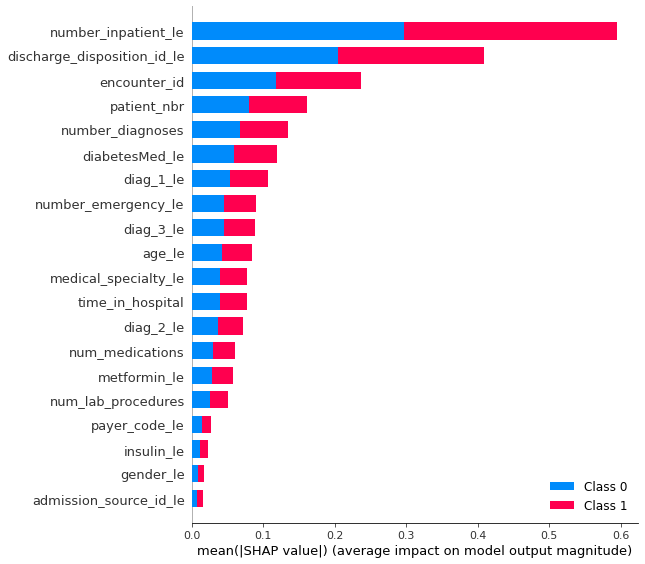

In [0]:
# training data summary plot
shap.summary_plot(xgb_shap_train, x_train_df)

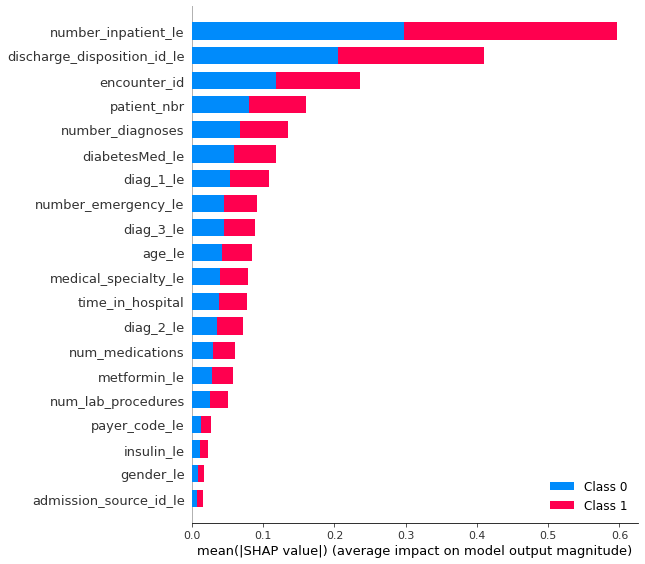

In [0]:
# test data summary plot
shap.summary_plot(xgb_shap_test, x_test_df)

As shown in the graph above the features that most derives the model in both the training and test data is the number_inpatient.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


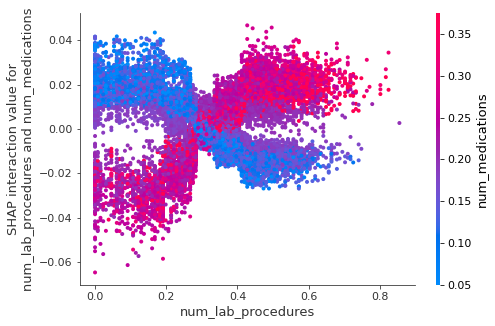

In [0]:
# We can also see how variables interact:
xgb_var_interactions = shap.TreeExplainer(lgbm_model).shap_interaction_values(x_test_df)
shap.dependence_plot(("num_lab_procedures", "num_medications"),
                     xgb_var_interactions, x_test_df,
                     display_features = x_test_df) 
#"num_lab_procedures", "num_medications"

This plot has an interesting shape. It shows that a low num_medications value represented in blue and values of num_lab_procedures less that 0.2 is pushing the model to better predictions. Similarly high num_medications represented in pink (higher than 0.2) and values of num_lab_procedures between 0.4 to 0.8 are also pusing the model to better predictions. 

Using hyperopt to perform gridsearch on one of the models. 

In [0]:
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK
import lightgbm as lgb

In [0]:
lightgbm_hp_train = lgb.Dataset(x_train, y_train)
lightgbm_hp_val = lgb.Dataset(x_val, y_val)

In [0]:
# Sets the space to search over and the prior probabilities over the search space 
import numpy as np
lgbm_space = {
    'boosting_type': hp.hp.choice('boosting_type',  ['gbdt']),
    'max_depth': hp.hp.choice('max_depth', np.arange(2, 100,1, dtype=int)),
    'num_leaves':hp.hp.choice('num_leaves', np.arange(10, 300,1, dtype=int)),
    #'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
    #'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
    'min_child_weight':hp.hp.quniform('min_child_weight', 100, 1000,100),
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 1000.0),
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 1000.0),
    'learning_rate': hp.hp.loguniform('learning_rate', -6, 0),
    #'feature_fraction': hp.hp.loguniform('feature_fraction', -4, 0),
    #'bagging_fraction': hp.hp.loguniform('bagging_fraction', -4, 0),
    #'bagging_frequency':hp.hp.choice('bagging_frequency', np.arange(5, 100,1, dtype=int)),
    #'drop_rate': hp.hp.loguniform('drop_rate', -4, 0),
    'scale_pos_weight': hp.hp.uniform('scale_pos_weight', 6.0, 10.0),
    'num_class' : 1, 
    'metric' : 'auc',
    'nthread': 6, 
    'max_bin': 512
    }

In [0]:
# define objective(loss) function
def objective_m(params, n_folds=5):
  model = lgb.cv(params = params,
                 train_set = lightgbm_hp_train,
                 num_boost_round = 1000,
                 early_stopping_rounds = 10,
                 nfold = n_folds)
  loss = 1 - (max(model['auc-mean']))
  return loss

bayes_trials = Trials()
MAX_EVALS = 100 # this controls the runtime 

lgbm_best_model = fmin(fn = objective_m, space = lgbm_space, algo = hp.tpe.suggest, 
max_evals = MAX_EVALS, trials = bayes_trials)


100%|██████████| 100/100 [18:07<00:00, 10.87s/it, best loss: 0.3211674245146314]


In [0]:
lgbm_best_model

{'boosting_type': 0,
 'learning_rate': 0.01720020300568784,
 'max_depth': 7,
 'min_child_weight': 200.0,
 'num_leaves': 132,
 'reg_alpha': 0.5214043263401056,
 'reg_lambda': 402.9533228392959,
 'scale_pos_weight': 8.516533486548212}

In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01720020300568784,
    'max_depth': 7,
    'min_child_weight': 200.0,
    'num_leaves': 132,
    'reg_alpha': 0.5214043263401056,
    'reg_lambda': 402.9533228392959,
    'scale_pos_weight': 8.516533486548212
        
}

In [0]:
lgbm_model = lgb.train(params = lgb_params, train_set = lightgbm_hp_train,
                num_boost_round = 100, valid_sets = [lightgbm_hp_val, lightgbm_hp_train],
               valid_names = ['Evaluation', 'Train'])

[1]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[2]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[3]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[4]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[5]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[6]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[7]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[8]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[9]	Train's auc: 0.591425	Evaluation's auc: 0.588872
[10]	Train's auc: 0.602881	Evaluation's auc: 0.600803
[11]	Train's auc: 0.602881	Evaluation's auc: 0.600803
[12]	Train's auc: 0.628826	Evaluation's auc: 0.624541
[13]	Train's auc: 0.631474	Evaluation's auc: 0.625467
[14]	Train's auc: 0.631556	Evaluation's auc: 0.625561
[15]	Train's auc: 0.631556	Evaluation's auc: 0.625561
[16]	Train's auc: 0.631556	Evaluation's auc: 0.625561
[17]	Train's auc: 0.631556	Evaluation's auc: 0.625561
[18]	Train's auc: 0.631556	Evaluation's auc: 0.625561
[19]	Train's auc: 0.631556	Evaluation

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_train, lgbm_model.predict(x_train))
print("Train AUC = ", metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, lgbm_model.predict(x_test))
print("Test AUC = ", metrics.auc(fpr, tpr))

Train AUC =  0.6671052017556722
Test AUC =  0.6658822476117041


Though from the train and test accuracy, the model looks neither underfit nor overfit, we know from Part 1, that we achieved better accuracy from manually tuning the parameters. Hence, we can say that this model is underfit.
To improve the model, we can alter the search space functions such as choice, normal and uniform to better accomodate the various hyperparameter values and increasing the number of parameters in the paramater space in hyperopt.